In [1]:
import warnings
warnings.filterwarnings("ignore")

import os.path
import ssm
import pickle
import numpy as np
import pandas as pd
import scipy
import copy
from tqdm import tqdm

from runwise_ts_log_data import get_ts_log_data_blocked

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns

from sympy.utilities.iterables import multiset_permutations
from ssm.util import *
from scipy.stats import ttest_ind

In [2]:
with open('pkl/emoprox2_dataset_timeseries+inputs_MAX85.pkl','rb') as f:
    orig_df = pickle.load(f)
subj_list = sorted(orig_df['pid'].unique())
subj_list = subj_list[:] # remove first 30 subjects
orig_df = orig_df[orig_df['pid'].isin(subj_list)]

In [3]:
K = 6
D = 10
N = 85
num_subjs = 92
num_resamples = 100

In [4]:
with open(f'pkl/rslds_emoprox2_K{K}_D{10}_N{N}_{122}subjs_5.pkl','rb') as f:
        model1,q1,elbos1,resampled_subj_list = pickle.load(f)

resampled_df = []
for pid in resampled_subj_list:
    resampled_df.append(orig_df[orig_df['pid']==pid])
resampled_df = pd.concat(resampled_df).reset_index().drop('index',axis=1)

df1 = resampled_df

df1['continuous_states'] = [None]*df1.shape[0]
df1['discrete_states'] =[None]*df1.shape[0]
hrflag=0
prox_bins = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
dir_bins = [0]
nprox = len(prox_bins)+1
ndir = len(dir_bins)+1
for idx_row in range(df1.shape[0]):
    prox = df1.loc[idx_row]['proximity']
    prox = prox - prox.min()
    prox = prox / prox.max()
    proxd = np.digitize(prox, bins=prox_bins)
    dird = 1-np.digitize(df1.loc[idx_row]['direction'], bins=dir_bins)
    stim_category = (nprox*ndir-1)*dird+((-1)**dird)*proxd
    input = np.roll(np.eye(nprox*ndir)[stim_category],shift=hrflag,axis=0)

    y = df1.loc[idx_row]['timeseries']
    x = q1.mean_continuous_states[idx_row]
    z = model1.most_likely_states(x,y,input=input)
    df1.at[idx_row,'continuous_states'] = x
    df1.at[idx_row,'discrete_states'] = z
    prox = df1.loc[idx_row]['proximity']
    prox = prox - prox.min()
    prox = prox / prox.max()
    df1.at[idx_row,'proximity'] = prox

In [5]:
def get_df(idx_resample):
    
    with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
        model,q,elbos,resampled_subj_list = pickle.load(f)
    # print(idx_resample,resampled_subj_list)
    resampled_df = []
    for pid in resampled_subj_list:
        resampled_df.append(orig_df[orig_df['pid']==pid])
    resampled_df = pd.concat(resampled_df).reset_index().drop('index',axis=1)

    df = resampled_df

    df['continuous_states'] = [None]*df.shape[0]
    df['discrete_states'] =[None]*df.shape[0]
    hrflag=0
    prox_bins = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    dir_bins = [0]
    nprox = len(prox_bins)+1
    ndir = len(dir_bins)+1
    for idx_row in range(df.shape[0]):
        prox = df.loc[idx_row]['proximity']
        prox = prox - prox.min()
        prox = prox / prox.max()
        proxd = np.digitize(prox, bins=prox_bins)
        dird = 1-np.digitize(df.loc[idx_row]['direction'], bins=dir_bins)
        stim_category = (nprox*ndir-1)*dird+((-1)**dird)*proxd
        input = np.roll(np.eye(nprox*ndir)[stim_category],shift=hrflag,axis=0)

        y = df.loc[idx_row]['timeseries']
        x = q.mean_continuous_states[idx_row]
        z = model.most_likely_states(x,y,input=input)
        df.at[idx_row,'continuous_states'] = x
        df.at[idx_row,'discrete_states'] = z
        prox = df.loc[idx_row]['proximity']
        prox = prox - prox.min()
        prox = prox / prox.max()
        df.at[idx_row,'proximity'] = prox
    
    states1 = []
    for idx_row in range(df.shape[0]):
        pid = df.loc[idx_row]['pid']
        rid = df.loc[idx_row]['rid']
        block = df.loc[idx_row]['block']
        states1 += list(df1[(df1.pid==pid)&(df1.rid==rid)&(df1.block==block)]['discrete_states'].values)
    states1 = np.hstack(states1)
    states2 = np.hstack(list(df['discrete_states'].values))
    # print(states1.shape, states2.shape)

    dist = np.Inf
    best_perm = None
    for perm in multiset_permutations(np.arange(K)):
        pi = np.array(perm)
        perm_states2 = pi[states2]
        if dist>(states1!=perm_states2).mean():
            dist = (states1!=perm_states2).mean()
            best_perm = pi

    best_perm_ssm = find_permutation(states2, states1)

    if np.all(np.array(best_perm)==np.array(best_perm_ssm)) == False:
        print(best_perm, best_perm_ssm)

    model.permute(best_perm)
    # for idx_row in range(df.shape[0]):
    #     y = df.loc[idx_row]['timeseries']
    #     x = df.loc[idx_row]['continuous_states']
    #     z = model.most_likely_states(x,y,input=input)
    #     df.at[idx_row,'discrete_states'] = z
    
    for idx_row in range(df.shape[0]):
        z = df.loc[idx_row]['discrete_states'].copy()
        z = best_perm[z]
        df.at[idx_row,'discrete_states'] = z
    
    return df,model

In [6]:
all_dfs = {}
all_models = {}
for idx_resample in tqdm(range(1,num_resamples+1)):
    all_dfs[idx_resample],all_models[idx_resample] = get_df(idx_resample)

100%|██████████| 100/100 [07:52<00:00,  4.72s/it]


In [7]:
with open(f'pkl/state_masks_K{K}_D{D}_N{N}_{num_subjs}subjs.pkl','rb') as f:
    state_masks = pickle.load(f)

In [8]:
def get_avg_activity(model,df):
    avg_activities = np.zeros((K,N))
    ys = np.vstack(list(df['timeseries'].values))
    zs = np.hstack(list(df['discrete_states'].values))
    for idx_state in range(K):
        avg_activities[idx_state,:] = ys[zs==idx_state,:].mean(axis=0)
    return avg_activities

In [9]:
all_attractors = {}
for idx_resample in tqdm(range(1,num_resamples+1)):
    attractors = get_avg_activity(all_models[idx_resample],all_dfs[idx_resample])
    state_mask = state_masks[idx_resample]
    for idx_state in range(K):
        if state_mask[idx_state] == 1:
            attractors[idx_state] = np.nan
    all_attractors[idx_resample] = attractors
all_attractors = np.stack(all_attractors.values())
res = scipy.stats.ttest_1samp(all_attractors, popmean=0, axis=0, nan_policy='omit', alternative='two-sided', keepdims=False)
mask = res.pvalue < (0.05)/(K)
avg_attractors = np.nanmean(all_attractors,axis=0)
# avg_attractors[~mask] = 0

100%|██████████| 100/100 [00:07<00:00, 14.24it/s]


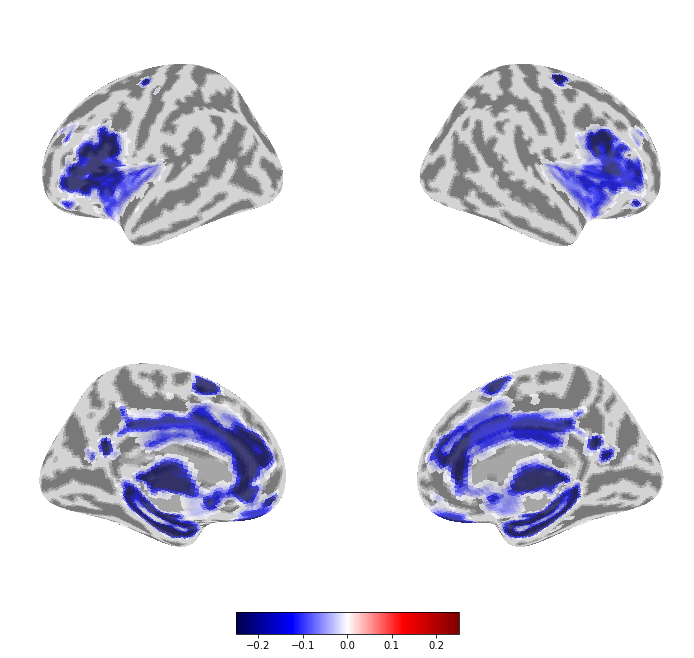

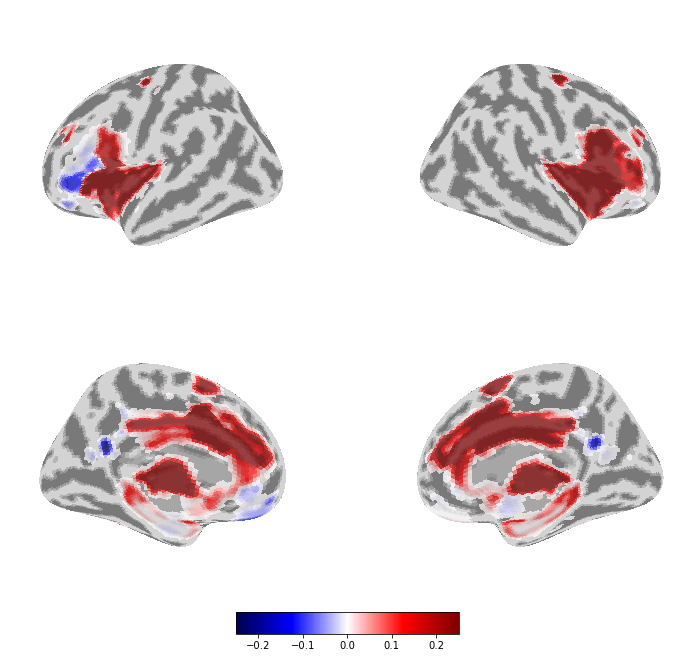

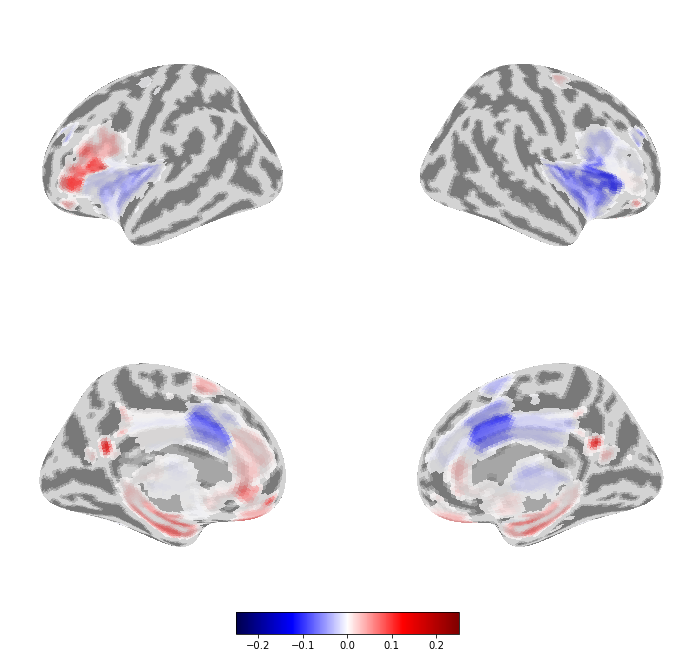

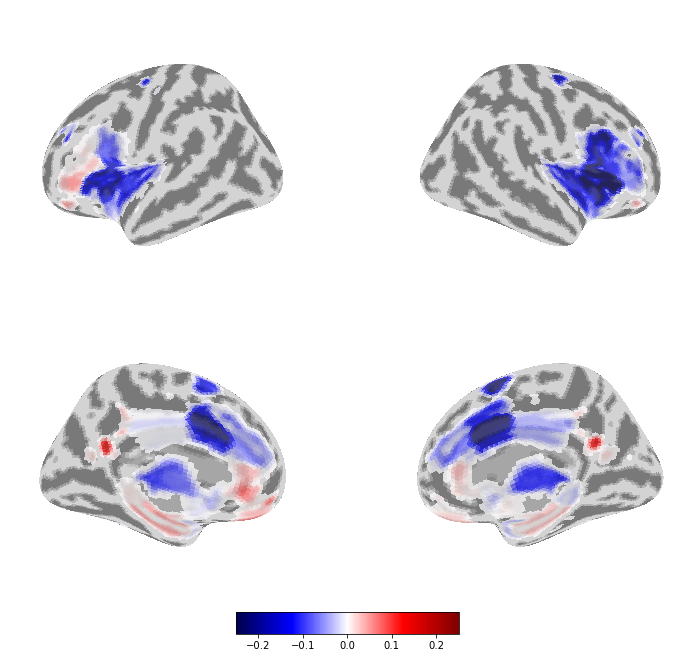

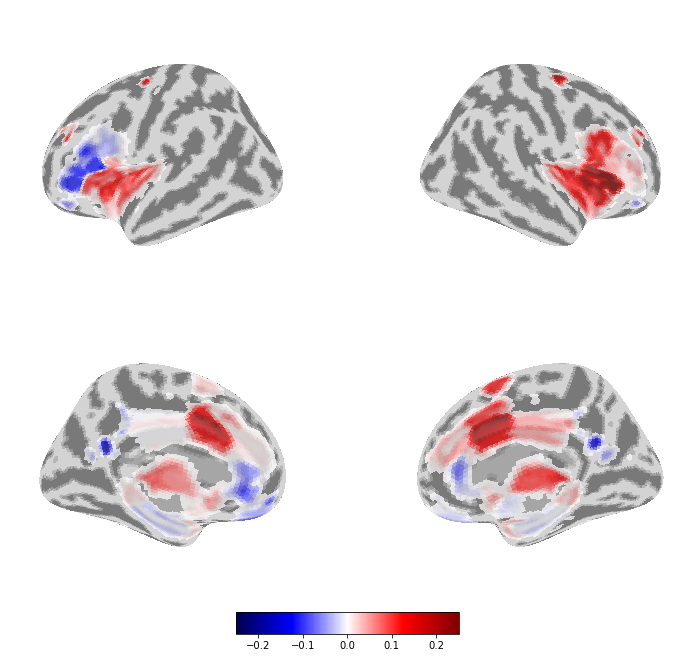

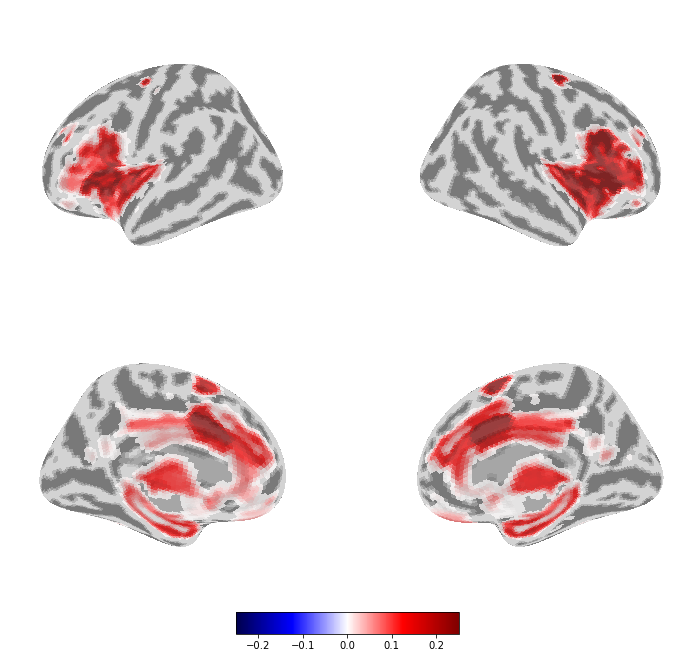

In [12]:
from nilearn.image import load_img, new_img_like
from nilearn import plotting
import cmasher as cmr
from nilearn import datasets

atlas = load_img('/home/joyneelm/templates/MAX_ROIs_final_gm_85.nii.gz')
atlas_data = atlas.get_fdata()
for idx_state in range(K):
    attractor = avg_attractors[idx_state,:]
    img_data = np.zeros_like(atlas_data)
    for idx_roi in range(1,N+1):
        img_data += (atlas_data==idx_roi)*attractor[idx_roi-1]
    img = new_img_like(ref_niimg=atlas,data=img_data, affine=None,copy_header=True)
    fig,ax = plotting.plot_img_on_surf(
        img,
        surf_mesh='fsaverage5',
        mask_img=None,
        hemispheres=['left','right'],
        bg_on_data=True,
        inflate=True,
        views=['lateral','medial'],
        output_file=None,
        title='',
        colorbar=True,
        vmax=0.25,#np.max(np.abs(attractor)),
        threshold=1e-9,
        symmetric_cbar=False,
        cmap='seismic',#cmr.pride,
        colorbar_fontsize=100
    )
    fig.set_size_inches(10.5, 10.5)
    fig.savefig(f'figures/fig_avg_activity{idx_state}_K{K}_D{D}_N{N}_{num_subjs}subjs.png',dpi=600,bbox_inches='tight')
        
